In [8]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from joblib import dump, load
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score 

In [38]:
def plot_importance(df, best_model, height, top_n=50):
    fi = pd.DataFrame(index = df.columns, columns = [])
    for i, m in enumerate(best_model):
        fi[f'm_{i}'] = m.get_feature_importance()

    fi = fi.stack().reset_index().iloc[:,[0, 2]]#.to_frame()
    fi.columns = ['feature','importance']

    cols_ord = list(fi.groupby('feature')['importance'].mean().sort_values(ascending=False).index)
    print('Всего признаков', len(cols_ord), f'Усреднее по {len(best_model)}-ти моделям: ')
    cols_ord = cols_ord[:top_n]
    
    fi = fi[fi['feature'].isin(cols_ord)]
    
    plt.figure(figsize=(10, len(cols_ord)*height))
    b = sns.boxplot(data=fi, y='feature', x='importance', orient='h', order=cols_ord)
    print(cols_ord)
    print(f'На график нанесено топ-{top_n} признаков')
    return fi.groupby(by =['feature'], as_index=False)['importance'].mean().sort_values(by='importance', ascending=False)


def get_predict_data(df, next_year, features = [], cat_features = []):
    current_year = next_year - 1
    last_year = next_year - 2
    base_year = next_year - 3
    head_metric = [
        'Основные средства , RUB',
         'Внеоборотные активы, RUB',
         'Дебиторская задолженность, RUB',
         'Оборотные активы, RUB',
         'Капитал и резервы, RUB',
         'Долгосрочные обязательства, RUB',
         'Кредиторская задолженность, RUB',
         'Краткосрочные обязательства, RUB',
         'Выручка, RUB',
         'Себестоимость продаж, RUB',
         'Прибыль (убыток) до налогообложения , RUB',
         'Прибыль (убыток) от продажи, RUB'
    ]
    resul_metrics = pd.DataFrame()
  
    for metric in head_metric:
        for_current = df[f'{current_year}, {metric}']
        for_last = df[f'{last_year}, {metric}']
        for_base = df[f'{base_year}, {metric}']
        growth_rate_current_last = for_current / for_last
        growth_rate_last_base = for_last / for_base

        incr_current_last = (for_current - for_last) / for_last
        incr_last_base = (for_last - for_base) / for_base
        resul_metrics[f'Темп роста за последний год {metric}'] = growth_rate_current_last
        resul_metrics[f'Темп роста за предыдущий год {metric}'] = growth_rate_last_base 
        resul_metrics[f'Темп роста средний {metric}'] = (growth_rate_current_last + growth_rate_last_base) / 2
        resul_metrics[f'Темп прироста за последний год {metric}'] = incr_current_last
        resul_metrics[f'Темп прироста за предыдущий год {metric}'] = incr_last_base
        resul_metrics[f'Темп прироста средний {metric}'] = (incr_current_last + incr_last_base) / 2
        
    #считаем рентабельности
    income = 'Выручка, RUB'
    profit = 'Прибыль (убыток) до налогообложения , RUB'
    income_current = df[f'{current_year}, {income}']
    income_last = df[f'{last_year}, {income}']
    income_base = df[f'{base_year}, {income}']
    profit_current = df[f'{current_year}, {profit}']
    profit_last = df[f'{last_year}, {profit}']
    profit_base = df[f'{base_year}, {profit}']
    profitability_current = income_current / profit_current
    profitability_last = income_last / profit_last
    profitability_base = income_base / profit_base
    
    resul_metrics[f'Рентабельность за последний год'] = profitability_current
    resul_metrics[f'Рентабельность за предыдущий год'] = profitability_last
    resul_metrics[f'Рентабельность за позопредыдущий год'] = profitability_base
    resul_metrics[f'Рентабельность средняя'] = (profitability_current + profitability_last + profitability_base) / 3
    resul_metrics[f'Прирост рентабельности'] = profitability_current - profitability_last
    
    # считаем Капиталооборот
    actives = 'Оборотные активы, RUB'
    actives_current = df[f'{current_year}, {actives}']
    actives_last = df[f'{last_year}, {actives}']
    actives_base = df[f'{base_year}, {actives}']
    resul_metrics[f'Капиталооборот за последний год'] = income_current / actives_current
    resul_metrics[f'Капиталооборот за предыдущий год'] = income_last / actives_last
    resul_metrics[f'Капиталооборот за позопредыдущий год'] = income_base / actives_base
    resul_metrics[f'Прирост Капиталооборот за последний год'] = (income_current / actives_current) - (income_last / actives_last)
    #resul_metrics = resul_metrics[~resul_metrics.isin([np.nan, np.inf, -np.inf]).any(1)]
    
    if len(features) > 0:
        resul_metrics = resul_metrics[features]
    if len(cat_features) > 0:
        resul_metrics[cat_features] = df[cat_features]
    
    for fact in fact_cols:
        resul_metrics[fact] = np.where((resul_metrics[fact] != 'Х'), 1, 0)
        resul_metrics[fact] = np.where((resul_metrics[fact] > 0), 'yes', 'no')
    resul_metrics = resul_metrics.copy()
    #resul_metrics.to_excel('data/fuck.xlsx')
    return resul_metrics


def get_answers(df, next_year):
    resul_metrics = pd.DataFrame()
    if next_year != 2021:
        max_pdz = df[f'Макс. ПДЗ за {next_year} год, дней']
        resul_metrics['Факт наличия ПДЗ'] = np.where((max_pdz > 365), 'yes', 'no')
    else:
        more_365 = df['ПДЗ более 365']
        between_91_365 = df['ПДЗ 91-365']
        between_31_90 = df['ПДЗ 31-90']
        between_1_30 = df['ПДЗ 1-30']
        condition = (between_1_30 == 1) | (between_31_90 == 1) | (between_91_365 == 1) | (more_365 == 1)
        resul_metrics['Факт наличия ПДЗ'] = np.where(condition, 'yes', 'no')
    #resul_metrics = resul_metrics[~resul_metrics.isin([np.nan, np.inf, -np.inf]).any(1)]
    resul_metrics = resul_metrics.copy()
    return resul_metrics


def get_answers_group(df, year, group_num):
    resul_metrics = pd.DataFrame()
    if year != 2021:
        max_pdz = df[f'Макс. ПДЗ за {year} год, дней']
        condition_1 = (max_pdz > 0) & (max_pdz <= 30)
        condition_30 = (max_pdz > 30) & (max_pdz <= 90)
        condition_90 = (max_pdz > 90) & (max_pdz <= 365)
        condition_365 = (max_pdz > 365)
    else:
        more_365 = df['ПДЗ более 365']
        between_91_365 = df['ПДЗ 91-365']
        between_31_90 = df['ПДЗ 31-90']
        between_1_30 = df['ПДЗ 1-30']
        condition_1 = (between_1_30 == 1) & (between_31_90 == 0) & (between_91_365 == 0) & (more_365 == 0)
        condition_30 = (between_31_90 == 1) & (between_91_365 == 0) & (more_365 == 0)
        condition_90 = (between_91_365 == 1) & (more_365 == 0)
        condition_365 = (more_365 == 1)
    if group_num == 1:
        resul_metrics['Группа ПДЗ 1-30'] = np.where(condition_1, 'yes', 'no')
    if group_num == 2:
        resul_metrics['Группа ПДЗ 31-90'] = np.where(condition_30, 'yes', 'no')
    if group_num == 3:
        resul_metrics['Группа ПДЗ 91-365'] = np.where(condition_90, 'yes', 'no')
    if group_num == 4:
        resul_metrics['Группа ПДЗ 365+'] = np.where(condition_365, 'yes', 'no')
    resul_metrics = resul_metrics.copy()
    return resul_metrics


def train(X, y):
    clfs = []
    scores = []
    n_splits = 5
    kFold_random_state = [73, 42 , 666, 322, 777, 2021, 2022, 2402, 1515]
    i = 1
    for ind_k, random_state in enumerate(kFold_random_state):
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            clf = CatBoostClassifier(iterations = 10000,
                                  loss_function = 'Logloss', eval_metric = 'F1',
                                  random_seed=random_state, 
                                  task_type='CPU', auto_class_weights = 'SqrtBalanced',
                                  early_stopping_rounds=1000)#,depth = 7)
                                  
            clfs.append(clf)

            clf.fit(X_train, y_train, eval_set=(X_test, y_test),
                    verbose = 500, use_best_model = True, plot = False)

            score = clf.best_score_['validation']['F1']
            scores.append(score)
            
            print(f'\t{i}, random state = {random_state}')
            print(f'\t\tmodel F1 = {score}')
            i += 1
    print(f'\t\tmodels mean F1 = {np.mean(scores)}')
    return clfs


def train_with_categories(X, y, cat_features):
    clfs = []
    scores = []
    n_splits = 5
    kFold_random_state = [73, 42 , 666, 322, 777, 2021, 2022, 2402, 1515]
    i = 1
    for ind_k, random_state in enumerate(kFold_random_state):
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            clf = CatBoostClassifier(iterations = 10000,
                                     cat_features = cat_features,
                                  loss_function = 'Logloss', eval_metric = 'F1',
                                  random_seed=random_state, 
                                  task_type='CPU', auto_class_weights = 'SqrtBalanced',
                                    early_stopping_rounds=500, depth = 7)
            clfs.append(clf)

            clf.fit(X_train, y_train, eval_set=(X_test, y_test),
                    verbose = 500, use_best_model = True, plot = False)

            score = clf.best_score_['validation']['F1']
            scores.append(score)
            i += 1
            print(f'\t{i}, random state = {random_state}')
            print(f'\t\tmodel F1 = {score}')
    print(f'models mean F1 = {np.mean(scores)}')
    return clfs


def test(models, X, y_true):
    i = 1
    accuracys = []
    f1s = []
    frame = pd.DataFrame()
    for model in models:
        y_pred = model.predict(X)
        f1_metric = f1_score(y_true, y_pred, pos_label='yes')
        f1s.append(f1_metric)
        accuracys.append(acc(y_pred, y_true))
        i += 1
        clfrep = classification_report(y_true=y_true, y_pred=y_pred)
        frame[f'y_pred_{i}'] = y_pred
        print(i)
        print(clfrep)
    print(f'{i} mean acuracy = {np.mean(accuracys)}')
    return frame


def test_accu(models, year):
    print(f'Тест на данных за {year} год')
    df = pd.read_csv(f"data/agents{year}.csv")
    X = get_predict_data(df, year)
    y_true = get_answers(df, year)
    frame = test(models, X, y_true)
    frame['true'] = y_true
    frame.to_excel(f'data/default/{year}.xlsx')


def test_accu_features(models, year, features):
    df = pd.read_csv(f"data/agents{year}.csv")
    X = pd.DataFrame()
    frame = get_predict_data(df, year, features)
    y_true = get_answers(df, year)
    X[features] = frame[features]
    frame = test(models, X, y_true)
    frame['true'] = y_true
    frame.to_excel(f'data/{year}.xlsx')


def test_accu_cat(models, year, features, cat_feature):
    df = pd.read_csv(f"data/agents{year}.csv")
    X = get_predict_data(df, year, features, cat_feature)
    y_true = get_answers(df, year)
    frame = test(models, X, y_true)
    frame['true'] = y_true
    frame.to_excel(f'data/{year}.xlsx')


def test_accu_cat_group(models, year, features, cat_feature, group_num):
    df = pd.read_csv(f"data/agents{year}.csv")
    X = get_predict_data(df, year, features, cat_feature)
    y_true = get_answers_group(df, year, group_num)
    frame = test(models, X, y_true)
    frame['true'] = y_true
    frame.to_excel(f'data/{group_num}/{year}.xlsx')

    
def dump_best(clfs, group, limit):
    i = 1
    scores = []
    best = []
    for clf in clfs:
        score = clf.best_score_['validation']['F1']
        if score > limit:
            scores.append(score)
            best.append(clf)
            print(f'{i} model acuracy = {score}')
            dump(clf, f'models/{group}/best/model_{i}.joblib')
            i += 1
    print('mean AUC', np.mean(scores))
    print('best AUC', np.max(scores))
    return best

# Сформировать перечень колонок по которым будем ориентироваться

# Подсчитать входные данные и расширить выборку

Для моделей, поддерживающих несколько групп классификации:


In [25]:
first_data_pack = pd.read_csv("data/agents2019.csv")

X = get_predict_data(first_data_pack, 2019)
#X = pd.concat([X, get_predict_data(first_data_pack, 2021)], ignore_index=True)

y = get_answers(first_data_pack, 2019)
#y = pd.concat([y, get_answers(first_data_pack, 2021)], ignore_index=True)

# Чистим от лишнего данные

In [26]:

X['Факт наличия ПДЗ'] = y['Факт наличия ПДЗ']
X = X[~X.isin([np.nan, np.inf, -np.inf]).any(1)]
X

,"Темп роста за последний год Основные средства , RUB","Темп роста за предыдущий год Основные средства , RUB","Темп роста средний Основные средства , RUB","Темп прироста за последний год Основные средства , RUB","Темп прироста за предыдущий год Основные средства , RUB","Темп прироста средний Основные средства , RUB","Темп роста за последний год Внеоборотные активы, RUB","Темп роста за предыдущий год Внеоборотные активы, RUB","Темп роста средний Внеоборотные активы, RUB","Темп прироста за последний год Внеоборотные активы, RUB",...,Рентабельность за последний год,Рентабельность за предыдущий год,Рентабельность за позопредыдущий год,Рентабельность средняя,Прирост рентабельности,Капиталооборот за последний год,Капиталооборот за предыдущий год,Капиталооборот за позопредыдущий год,Прирост Капиталооборот за последний год,Факт наличия ПДЗ
0,1.189339,0.954491,1.071915,0.189339,-0.045509,0.071915,1.297333,0.975194,1.136263,0.297333,...,49.638671,6.749218,8.389787,21.592559,42.889452,6.094585,7.058611,5.170578,-0.964026,no
1,1.026409,1.026962,1.026686,0.026409,0.026962,0.026686,1.027328,1.028284,1.027806,0.027328,...,12.129974,37.060075,21.073815,23.421288,-24.930101,1.864488,1.355285,1.715672,0.509203,no
2,0.983400,0.973820,0.978610,-0.016600,-0.026180,-0.021390,0.982893,1.064871,1.023882,-0.017107,...,30.310094,7.407319,5.543593,14.420335,22.902775,1.630231,1.812791,2.165312,-0.182560,no
3,1.344507,1.195585,1.270046,0.344507,0.195585,0.270046,1.422043,1.165871,1.293957,0.422043,...,3.166079,3.969723,4.119921,3.751907,-0.803644,2.731163,3.295726,3.489092,-0.564562,no
4,1.023952,1.115991,1.069972,0.023952,0.115991,0.069972,0.958441,0.937999,0.948220,-0.041559,...,1.874760,1.752233,0.658424,1.428472,0.122528,4.145944,7.085766,5.732176,-2.939821,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,0.952196,0.945829,0.949012,-0.047804,-0.054171,-0.050988,0.950556,0.955741,0.953148,-0.049444,...,23.010216,144.717944,-28.885063,46.281032,-121.707728,3.630880,4.613152,5.745613,-0.982272,no
517,0.896288,0.892976,0.894632,-0.103712,-0.107024,-0.105368,0.912718,0.893861,0.903289,-0.087282,...,65.813005,118.784634,24.636849,69.744830,-52.971630,6.777515,6.012573,8.409333,0.764942,no
518,0.656628,0.731257,0.693943,-0.343372,-0.268743,-0.306057,0.656628,0.731257,0.693943,-0.343372,...,12.720083,14.381498,21.329882,16.143821,-1.661415,2.931399,4.680705,7.960801,-1.749306,no
527,0.902303,0.890556,0.896429,-0.097697,-0.109444,-0.103571,0.843926,0.958609,0.901267,-0.156074,...,14.772737,8.552841,9.646361,10.990646,6.219896,3.127851,2.366278,3.804219,0.761573,no


# разделяем входные данные

In [27]:
y = X['Факт наличия ПДЗ']
X = X.drop(['Факт наличия ПДЗ'], axis = 1)
X

,"Темп роста за последний год Основные средства , RUB","Темп роста за предыдущий год Основные средства , RUB","Темп роста средний Основные средства , RUB","Темп прироста за последний год Основные средства , RUB","Темп прироста за предыдущий год Основные средства , RUB","Темп прироста средний Основные средства , RUB","Темп роста за последний год Внеоборотные активы, RUB","Темп роста за предыдущий год Внеоборотные активы, RUB","Темп роста средний Внеоборотные активы, RUB","Темп прироста за последний год Внеоборотные активы, RUB",...,"Темп прироста средний Прибыль (убыток) от продажи, RUB",Рентабельность за последний год,Рентабельность за предыдущий год,Рентабельность за позопредыдущий год,Рентабельность средняя,Прирост рентабельности,Капиталооборот за последний год,Капиталооборот за предыдущий год,Капиталооборот за позопредыдущий год,Прирост Капиталооборот за последний год
0,1.189339,0.954491,1.071915,0.189339,-0.045509,0.071915,1.297333,0.975194,1.136263,0.297333,...,0.015328,49.638671,6.749218,8.389787,21.592559,42.889452,6.094585,7.058611,5.170578,-0.964026
1,1.026409,1.026962,1.026686,0.026409,0.026962,0.026686,1.027328,1.028284,1.027806,0.027328,...,1.655344,12.129974,37.060075,21.073815,23.421288,-24.930101,1.864488,1.355285,1.715672,0.509203
2,0.983400,0.973820,0.978610,-0.016600,-0.026180,-0.021390,0.982893,1.064871,1.023882,-0.017107,...,-1.094351,30.310094,7.407319,5.543593,14.420335,22.902775,1.630231,1.812791,2.165312,-0.182560
3,1.344507,1.195585,1.270046,0.344507,0.195585,0.270046,1.422043,1.165871,1.293957,0.422043,...,0.287594,3.166079,3.969723,4.119921,3.751907,-0.803644,2.731163,3.295726,3.489092,-0.564562
4,1.023952,1.115991,1.069972,0.023952,0.115991,0.069972,0.958441,0.937999,0.948220,-0.041559,...,0.508797,1.874760,1.752233,0.658424,1.428472,0.122528,4.145944,7.085766,5.732176,-2.939821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,0.952196,0.945829,0.949012,-0.047804,-0.054171,-0.050988,0.950556,0.955741,0.953148,-0.049444,...,-0.203216,23.010216,144.717944,-28.885063,46.281032,-121.707728,3.630880,4.613152,5.745613,-0.982272
517,0.896288,0.892976,0.894632,-0.103712,-0.107024,-0.105368,0.912718,0.893861,0.903289,-0.087282,...,0.133135,65.813005,118.784634,24.636849,69.744830,-52.971630,6.777515,6.012573,8.409333,0.764942
518,0.656628,0.731257,0.693943,-0.343372,-0.268743,-0.306057,0.656628,0.731257,0.693943,-0.343372,...,-0.055171,12.720083,14.381498,21.329882,16.143821,-1.661415,2.931399,4.680705,7.960801,-1.749306
527,0.902303,0.890556,0.896429,-0.097697,-0.109444,-0.103571,0.843926,0.958609,0.901267,-0.156074,...,-0.264744,14.772737,8.552841,9.646361,10.990646,6.219896,3.127851,2.366278,3.804219,0.761573


In [28]:
y

0      no
1      no
2      no
3      no
4      no
       ..
512    no
517    no
518    no
527    no
529    no
Name: Факт наличия ПДЗ, Length: 269, dtype: object

# Готовим модель

In [29]:
clfs = train(X, y)

Learning rate set to 0.007962
0:	learn: 0.7425229	test: 0.0000000	best: 0.0000000 (0)	total: 6.61ms	remaining: 1m 6s
500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 2.66s	remaining: 50.4s
1000:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 5.26s	remaining: 47.3s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	1, random state = 73
		model F1 = 0.0
Learning rate set to 0.007962
0:	learn: 0.7905380	test: 0.0000000	best: 0.0000000 (0)	total: 22ms	remaining: 3m 39s
500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 2.7s	remaining: 51.2s
1000:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 5.43s	remaining: 48.8s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	2, random state = 73
		model F1 = 0.0
Learning rate set to 0.007962
0:	learn: 0.7153428	test: 0.0000000	best: 0.0000000 (0)	

500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 3.17s	remaining: 1m
1000:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 6.15s	remaining: 55.3s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	19, random state = 322
		model F1 = 0.0
Learning rate set to 0.007971
0:	learn: 0.6350970	test: 0.0000000	best: 0.0000000 (0)	total: 6.26ms	remaining: 1m 2s
500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 3.09s	remaining: 58.6s
1000:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 6.47s	remaining: 58.2s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	20, random state = 322
		model F1 = 0.0
Learning rate set to 0.007962
0:	learn: 0.7990439	test: 0.0000000	best: 0.0000000 (0)	total: 16.9ms	remaining: 2m 48s
500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 3.23s	remaining: 

500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 3.03s	remaining: 57.4s
1000:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 6.08s	remaining: 54.7s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	37, random state = 2402
		model F1 = 0.0
Learning rate set to 0.007962
0:	learn: 0.9152631	test: 0.0000000	best: 0.0000000 (0)	total: 19.5ms	remaining: 3m 15s
500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 3.04s	remaining: 57.7s
1000:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 6.15s	remaining: 55.3s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	38, random state = 2402
		model F1 = 0.0
Learning rate set to 0.007962
0:	learn: 0.6611188	test: 0.0000000	best: 0.0000000 (0)	total: 6.17ms	remaining: 1m 1s
500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 3.12s	remain

In [30]:
i = 1
scores = []
for clf in clfs:
    score = clf.best_score_['validation']['F1']
    scores.append(score)
    dump(clf, f'models/default/model_{i}.joblib')
    print(f'{i} model F1 = {score}')
    i += 1
print('mean F1', np.mean(scores))
print('max F1', np.max(scores))

1 model F1 = 0.0
2 model F1 = 0.0
3 model F1 = 0.0
4 model F1 = 0.32079933809738115
5 model F1 = 1.0
6 model F1 = 0.0
7 model F1 = 0.0
8 model F1 = 0.0
9 model F1 = 0.0
10 model F1 = 0.9106986504422799
11 model F1 = 0.0
12 model F1 = 0.47864792104266013
13 model F1 = 1.0
14 model F1 = 0.0
15 model F1 = 0.0
16 model F1 = 0.0
17 model F1 = 1.0
18 model F1 = 0.0
19 model F1 = 0.0
20 model F1 = 0.0
21 model F1 = 0.0
22 model F1 = 0.0
23 model F1 = 1.0
24 model F1 = 0.0
25 model F1 = 0.38805284146586083
26 model F1 = 0.0
27 model F1 = 0.0
28 model F1 = 0.5940182920337166
29 model F1 = 0.0
30 model F1 = 0.0
31 model F1 = 0.0
32 model F1 = 0.0
33 model F1 = 0.0
34 model F1 = 0.0
35 model F1 = 0.6283359841639408
36 model F1 = 0.0
37 model F1 = 0.0
38 model F1 = 0.0
39 model F1 = 0.0
40 model F1 = 1.0
41 model F1 = 1.0
42 model F1 = 1.0
43 model F1 = 0.0
44 model F1 = 0.0
45 model F1 = 0.0
mean F1 0.22934562282768534
max F1 1.0


1 model F1 = 1.0
2 model F1 = 0.9106986504422799
3 model F1 = 1.0
4 model F1 = 1.0
5 model F1 = 1.0
6 model F1 = 0.5940182920337166
7 model F1 = 0.6283359841639408
8 model F1 = 1.0
9 model F1 = 1.0
10 model F1 = 1.0
mean model F1 = 0.9133052926639937
Всего признаков 81 Усреднее по 10-ти моделям: 
['Рентабельность за последний год', 'Темп роста средний Прибыль (убыток) от продажи, RUB', 'Темп роста за предыдущий год Прибыль (убыток) от продажи, RUB', 'Темп прироста средний Прибыль (убыток) от продажи, RUB', 'Темп прироста за предыдущий год Оборотные активы, RUB', 'Рентабельность средняя', 'Темп роста за предыдущий год Капитал и резервы, RUB', 'Темп роста за последний год Основные средства , RUB', 'Темп прироста за предыдущий год Прибыль (убыток) до налогообложения , RUB', 'Темп прироста за последний год Прибыль (убыток) до налогообложения , RUB', 'Темп роста за последний год Прибыль (убыток) от продажи, RUB', 'Темп роста средний Основные средства , RUB', 'Темп роста за последний год Кра

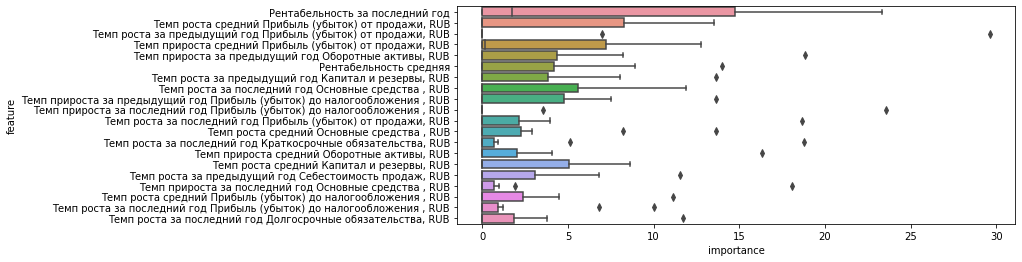

In [36]:
top = []
i = 1
scores = []
for clf in clfs:
    score = clf.best_score_['validation']['F1']
    if score > 0.55:
        scores.append(score)
        top.append(clf)
        dump(clf, f'models/default/best/model_{i}.joblib')
        print(f'{i} model F1 = {score}')
        i += 1
print(f'mean model F1 = {np.mean(scores)}')
df_feats_imp = plot_importance(X, top, 0.20, top_n=20)

# Из графика видно, что
Можно выделить 20 показателей, на которые в наибольшей степени ориентирловались модели, а именно:

'Рентабельность за последний год', 'Темп прироста за предыдущий год Внеоборотные активы, RUB', 'Темп прироста за предыдущий год Себестоимость продаж, RUB', 'Темп прироста за последний год Выручка, RUB', 'Темп прироста за предыдущий год Дебиторская задолженность, RUB', 'Темп роста за последний год Кредиторская задолженность, RUB', 'Темп роста за последний год Оборотные активы, RUB', 'Темп роста средний Оборотные активы, RUB', 'Темп роста за предыдущий год Капитал и резервы, RUB', 'Темп роста средний Долгосрочные обязательства, RUB', 'Темп роста за последний год Себестоимость продаж, RUB', 'Темп роста за последний год Краткосрочные обязательства, RUB', 'Темп роста за последний год Прибыль (убыток) до налогообложения , RUB', 'Темп роста за последний год Капитал и резервы, RUB', 'Рентабельность за предыдущий год', 'Темп прироста за последний год Дебиторская задолженность, RUB', 'Темп роста за предыдущий год Внеоборотные активы, RUB', 'Темп роста за последний год Долгосрочные обязательства, RUB', 'Темп прироста за предыдущий год Прибыль (убыток) от продажи, RUB', 'Темп прироста за предыдущий год Капитал и резервы, RUB'
 
 

In [60]:
models = []
for i in range(1, 11):
    models.append(load(f'models/default/best/model_{i}.joblib'))

test_2019(models)
test_2020(models)
test_2021(models)

2
              precision    recall  f1-score   support

          no       0.99      0.89      0.94       519
         yes       0.11      0.58      0.18        12

    accuracy                           0.88       531
   macro avg       0.55      0.74      0.56       531
weighted avg       0.97      0.88      0.92       531

3
              precision    recall  f1-score   support

          no       0.99      0.95      0.97       519
         yes       0.26      0.75      0.38        12

    accuracy                           0.95       531
   macro avg       0.63      0.85      0.68       531
weighted avg       0.98      0.95      0.96       531

4
              precision    recall  f1-score   support

          no       0.99      0.99      0.99       519
         yes       0.70      0.58      0.64        12

    accuracy                           0.98       531
   macro avg       0.85      0.79      0.81       531
weighted avg       0.98      0.98      0.98       531

5
           

C:\Users\drizh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\drizh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\drizh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2
              precision    recall  f1-score   support

          no       0.66      0.98      0.79       214
         yes       0.29      0.02      0.03       111

    accuracy                           0.65       325
   macro avg       0.47      0.50      0.41       325
weighted avg       0.53      0.65      0.53       325

3
              precision    recall  f1-score   support

          no       0.65      0.91      0.76       214
         yes       0.30      0.07      0.12       111

    accuracy                           0.62       325
   macro avg       0.48      0.49      0.44       325
weighted avg       0.53      0.62      0.54       325

4
              precision    recall  f1-score   support

          no       0.67      1.00      0.80       214
         yes       0.80      0.04      0.07       111

    accuracy                           0.67       325
   macro avg       0.73      0.52      0.43       325
weighted avg       0.71      0.67      0.55       325

5
           

C:\Users\drizh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\drizh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\drizh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Обучаем на 20 самых важных признаках

In [14]:
first_data_pack = pd.read_csv("data/agents2021.csv")



y = get_answers(first_data_pack, 2019)
y = pd.concat([y, get_answers(first_data_pack, 2021)], ignore_index=True)
features = ['Рентабельность за последний год', 'Капиталооборот за позопредыдущий год', 'Темп роста за последний год Себестоимость продаж, RUB', 'Темп роста за последний год Прибыль (убыток) от продажи, RUB', 'Темп прироста за последний год Внеоборотные активы, RUB', 'Темп роста за последний год Внеоборотные активы, RUB', 'Темп прироста за предыдущий год Прибыль (убыток) до налогообложения , RUB', 'Темп роста средний Капитал и резервы, RUB', 'Темп роста за последний год Краткосрочные обязательства, RUB', 'Темп роста средний Прибыль (убыток) от продажи, RUB', 'Темп роста за предыдущий год Себестоимость продаж, RUB', 'Рентабельность средняя', 'Темп роста средний Основные средства , RUB', 'Темп роста за предыдущий год Капитал и резервы, RUB', 'Темп роста за предыдущий год Долгосрочные обязательства, RUB', 'Темп прироста средний Основные средства , RUB', 'Темп роста за предыдущий год Кредиторская задолженность, RUB', 'Темп роста за последний год Основные средства , RUB', 'Темп прироста средний Капитал и резервы, RUB', 'Темп прироста за предыдущий год Прибыль (убыток) от продажи, RUB']
X = get_predict_data(first_data_pack, 2019, features)
X = pd.concat([X, get_predict_data(first_data_pack, 2021, features)], ignore_index=True)

X['Факт наличия ПДЗ'] = y['Факт наличия ПДЗ']
X = X[~X.isin([np.nan, np.inf, -np.inf]).any(1)]
y = X['Факт наличия ПДЗ']
X = X.drop(['Факт наличия ПДЗ'], axis = 1)


In [15]:
X

,Рентабельность за последний год,"Темп роста средний Прибыль (убыток) от продажи, RUB","Темп роста за предыдущий год Прибыль (убыток) от продажи, RUB","Темп прироста средний Прибыль (убыток) от продажи, RUB","Темп прироста за предыдущий год Оборотные активы, RUB",Рентабельность средняя,"Темп роста за предыдущий год Капитал и резервы, RUB","Темп роста за последний год Основные средства , RUB","Темп прироста за предыдущий год Прибыль (убыток) до налогообложения , RUB","Темп прироста за последний год Прибыль (убыток) до налогообложения , RUB","Темп роста за последний год Прибыль (убыток) от продажи, RUB","Темп роста средний Основные средства , RUB","Темп роста за последний год Краткосрочные обязательства, RUB","Темп прироста средний Оборотные активы, RUB","Темп роста средний Капитал и резервы, RUB","Темп роста за предыдущий год Себестоимость продаж, RUB","Темп прироста за последний год Основные средства , RUB","Темп роста средний Прибыль (убыток) до налогообложения , RUB","Темп роста за последний год Прибыль (убыток) до налогообложения , RUB","Темп роста за последний год Долгосрочные обязательства, RUB"
0,49.638671,1.015328,1.890076,0.015328,0.143030,21.592559,1.111483,1.189339,0.939703,-0.879017,0.140581,1.071915,1.309762,0.086786,0.941009,1.546467,0.189339,1.030343,0.120983,1.047294
1,30.310094,-0.094351,0.388402,-1.094351,0.157093,14.420335,1.108516,0.983400,-0.275020,-0.765300,-0.577104,0.978610,1.304966,0.112505,1.062649,1.068949,-0.016600,0.479840,0.234700,0.240377
2,1.874760,1.508797,1.593897,0.508797,0.141912,1.428472,0.379385,1.023952,-0.469588,0.208887,1.423698,1.069972,1.638603,0.676238,1.123556,1.199919,0.023952,0.869650,1.208887,0.949191
3,1.329156,1.628903,1.707707,0.628903,0.062836,1.838171,0.919641,1.001501,0.875003,0.862857,1.550099,1.005930,1.061551,0.326451,1.133370,1.456537,0.001501,1.868930,1.862857,0.992897
4,6.126646,1.432023,1.307681,0.432023,0.291334,4.563954,0.428769,0.968588,-0.513622,0.096965,1.556365,1.052219,0.464664,0.170233,0.483814,1.144576,-0.031412,0.791671,1.096965,1.243932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,-21.380912,0.003593,-0.467528,-0.996407,0.086613,0.168537,0.478982,0.940105,-2.807390,-0.515927,0.474715,1.003252,1.273711,0.076105,0.549894,0.919959,-0.059895,-0.661659,0.484073,0.921586
638,26.244441,1.450128,0.754964,0.450128,0.261298,35.403634,1.184552,1.187845,1.168380,0.443069,2.145292,1.069678,2.410501,2.329784,1.153133,0.709141,0.187845,1.805725,1.443069,664.573734
639,44.244729,-0.324840,0.468264,-1.324840,0.503315,65.116581,1.048159,1.396364,-0.325930,2.150921,-1.117944,1.778202,1.270419,0.366281,1.112493,0.986608,0.396364,1.912496,3.150921,1.920455
643,33.977632,2.538941,4.361171,1.538941,0.488796,55.513573,4.134405,0.623131,2.262061,-0.053131,0.716711,0.458757,1.343751,0.474335,2.938227,0.932895,-0.376869,2.104465,0.946869,2.497312


In [16]:
y

0       no
1       no
2       no
3       no
4       no
      ... 
637    yes
638    yes
639     no
643     no
648     no
Name: Факт наличия ПДЗ, Length: 409, dtype: object

In [17]:
clfs = train(X, y)

Learning rate set to 0.008831
0:	learn: 0.6695420	test: 0.3316851	best: 0.3316851 (0)	total: 156ms	remaining: 26m 4s
500:	learn: 0.9938650	test: 0.2829288	best: 0.3602509 (24)	total: 1.19s	remaining: 22.6s
1000:	learn: 1.0000000	test: 0.2829288	best: 0.3602509 (24)	total: 2.21s	remaining: 19.9s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.360250891
bestIteration = 24

Shrink model to first 25 iterations.
	1, random state = 73
		model F1 = 0.360250891042709
Learning rate set to 0.008831
0:	learn: 0.6270816	test: 0.3986082	best: 0.3986082 (0)	total: 33.5ms	remaining: 5m 35s
500:	learn: 0.9934641	test: 0.2358507	best: 0.4345841 (1)	total: 1.07s	remaining: 20.3s
1000:	learn: 1.0000000	test: 0.2308154	best: 0.4345841 (1)	total: 2.13s	remaining: 19.1s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.4345841117
bestIteration = 1

Shrink model to first 2 iterations.
	2, random state = 73
		model F1 = 0.43458411174211853
Learning rate set to 0.00883

500:	learn: 1.0000000	test: 0.3799885	best: 0.4418294 (0)	total: 1.17s	remaining: 22.1s
1000:	learn: 1.0000000	test: 0.3799885	best: 0.4418294 (0)	total: 2.32s	remaining: 20.9s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.441829369
bestIteration = 0

Shrink model to first 1 iterations.
	18, random state = 322
		model F1 = 0.4418293689745613
Learning rate set to 0.008831
0:	learn: 0.4861641	test: 0.1927317	best: 0.1927317 (0)	total: 4.27ms	remaining: 42.7s
500:	learn: 0.9781022	test: 0.3744876	best: 0.4170927 (19)	total: 1.13s	remaining: 21.5s
1000:	learn: 1.0000000	test: 0.3221256	best: 0.4170927 (19)	total: 2.23s	remaining: 20.1s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.4170926659
bestIteration = 19

Shrink model to first 20 iterations.
	19, random state = 322
		model F1 = 0.41709266590078264
Learning rate set to 0.008838
0:	learn: 0.5162907	test: 0.3168620	best: 0.3168620 (0)	total: 16.6ms	remaining: 2m 46s
500:	learn: 1.0000000	t

500:	learn: 1.0000000	test: 0.4198799	best: 0.4987638 (0)	total: 1.14s	remaining: 21.5s
1000:	learn: 1.0000000	test: 0.4300508	best: 0.4987638 (0)	total: 2.39s	remaining: 21.5s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.4987638111
bestIteration = 0

Shrink model to first 1 iterations.
	35, random state = 2022
		model F1 = 0.4987638111450312
Learning rate set to 0.008831
0:	learn: 0.5900021	test: 0.2729286	best: 0.2729286 (0)	total: 2.88ms	remaining: 28.8s
500:	learn: 0.9873418	test: 0.2801819	best: 0.3892398 (1)	total: 1.23s	remaining: 23.4s
1000:	learn: 1.0000000	test: 0.1906235	best: 0.4270828 (542)	total: 2.42s	remaining: 21.7s
1500:	learn: 1.0000000	test: 0.1906235	best: 0.4270828 (542)	total: 3.59s	remaining: 20.3s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.4270828194
bestIteration = 542

Shrink model to first 543 iterations.
	36, random state = 2402
		model F1 = 0.42708281939487025
Learning rate set to 0.008831
0:	learn: 0.431

In [18]:
i = 1
scores = []
best = []
for clf in clfs:
    score = clf.best_score_['validation']['F1']
    if score >  0.5:
        scores.append(score)
        best.append(clf)
        print(f'{i} model acuracy = {score}')
        dump(clf, f'models/6params/best/model_{i}.joblib')
        i += 1
print('mean F1', np.mean(scores))
print('max F1', np.max(scores))


1 model acuracy = 0.5584488719846373
2 model acuracy = 0.5916844585074722
3 model acuracy = 0.5960920490756814
4 model acuracy = 0.5149297945145116
5 model acuracy = 0.5965251374739549
6 model acuracy = 0.6621613709487809
7 model acuracy = 0.5207024168721356
8 model acuracy = 0.547925500924766
9 model acuracy = 0.5751490931778179
10 model acuracy = 0.6644402371368469
11 model acuracy = 0.5950911740911875
12 model acuracy = 0.5622088570412803
13 model acuracy = 0.56
14 model acuracy = 0.5612827504082953
mean F1 0.5790458365826693
max F1 0.6644402371368469


Всего признаков 20 Усреднее по 14-ти моделям: 
['Рентабельность за последний год', 'Темп роста за предыдущий год Себестоимость продаж, RUB', 'Темп прироста за предыдущий год Прибыль (убыток) до налогообложения , RUB', 'Темп роста средний Капитал и резервы, RUB', 'Темп прироста средний Оборотные активы, RUB', 'Рентабельность средняя', 'Темп роста за последний год Долгосрочные обязательства, RUB', 'Темп роста средний Прибыль (убыток) до налогообложения , RUB', 'Темп роста за предыдущий год Прибыль (убыток) от продажи, RUB', 'Темп прироста за предыдущий год Оборотные активы, RUB', 'Темп роста за последний год Основные средства , RUB', 'Темп прироста за последний год Основные средства , RUB', 'Темп роста за предыдущий год Капитал и резервы, RUB', 'Темп прироста за последний год Прибыль (убыток) до налогообложения , RUB', 'Темп роста за последний год Краткосрочные обязательства, RUB', 'Темп роста за последний год Прибыль (убыток) от продажи, RUB', 'Темп роста средний Основные средства , RUB

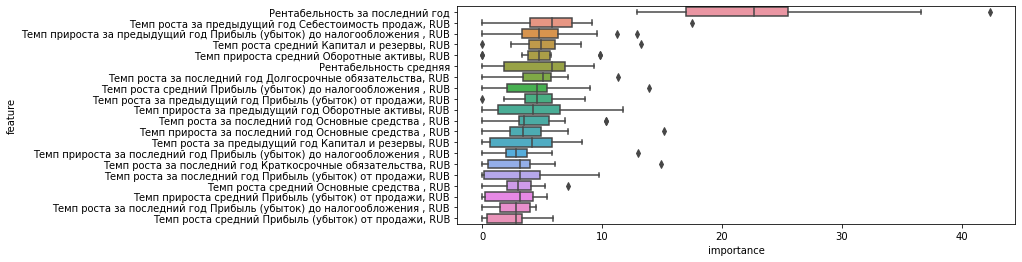

In [19]:
df_feats_imp = plot_importance(X, best, 0.20, top_n=20)

# ПРоверяем на данных за 2019, 2020, 2021

In [20]:

models = []
for i in range(1, 15):
    models.append(load(f'models/6params/best/model_{i}.joblib'))

test_accu_features(models, 2019, features)
test_accu_features(models, 2020, features)
test_accu_features(models, 2021, features)


2
              precision    recall  f1-score   support

          no       1.00      0.86      0.92       519
         yes       0.12      0.83      0.21        12

    accuracy                           0.85       531
   macro avg       0.56      0.84      0.56       531
weighted avg       0.98      0.85      0.90       531

3
              precision    recall  f1-score   support

          no       0.99      0.86      0.92       519
         yes       0.11      0.75      0.19        12

    accuracy                           0.86       531
   macro avg       0.55      0.80      0.56       531
weighted avg       0.97      0.86      0.90       531

4
              precision    recall  f1-score   support

          no       0.99      0.84      0.91       519
         yes       0.10      0.75      0.17        12

    accuracy                           0.83       531
   macro avg       0.54      0.79      0.54       531
weighted avg       0.97      0.83      0.89       531

5
           

13
              precision    recall  f1-score   support

          no       0.99      0.88      0.93       525
         yes       0.03      0.33      0.06         6

    accuracy                           0.87       531
   macro avg       0.51      0.61      0.49       531
weighted avg       0.98      0.87      0.92       531

14
              precision    recall  f1-score   support

          no       0.99      0.91      0.95       525
         yes       0.02      0.17      0.04         6

    accuracy                           0.90       531
   macro avg       0.51      0.54      0.49       531
weighted avg       0.98      0.90      0.94       531

15
              precision    recall  f1-score   support

          no       0.99      0.88      0.93       525
         yes       0.02      0.17      0.03         6

    accuracy                           0.87       531
   macro avg       0.50      0.52      0.48       531
weighted avg       0.98      0.87      0.92       531

15 mean ac

# Итогом разработки стала модель предсказывающая по минимальному набору параметров потенциальную возможность ПДЗ

Наша модель не учитывает влияние внешних факторов, что и может приводить к ошибке в 2,3%


# Попробуем добавить признаки группы "Факт"

In [45]:
data_pack = pd.read_csv("data/agents2021.csv")
header = list(data_pack.columns.values)
fact_cols = []
for head in header:
    if head.startswith("Факт"):
        fact_cols.append(head)

y = get_answers(data_pack, 2021)
features = ['Рентабельность за последний год', 'Капиталооборот за позопредыдущий год', 'Темп роста за последний год Себестоимость продаж, RUB', 'Темп роста за последний год Прибыль (убыток) от продажи, RUB', 'Темп прироста за последний год Внеоборотные активы, RUB', 'Темп роста за последний год Внеоборотные активы, RUB', 'Темп прироста за предыдущий год Прибыль (убыток) до налогообложения , RUB', 'Темп роста средний Капитал и резервы, RUB', 'Темп роста за последний год Краткосрочные обязательства, RUB', 'Темп роста средний Прибыль (убыток) от продажи, RUB', 'Темп роста за предыдущий год Себестоимость продаж, RUB', 'Рентабельность средняя', 'Темп роста средний Основные средства , RUB', 'Темп роста за предыдущий год Капитал и резервы, RUB', 'Темп роста за предыдущий год Долгосрочные обязательства, RUB', 'Темп прироста средний Основные средства , RUB', 'Темп роста за предыдущий год Кредиторская задолженность, RUB', 'Темп роста за последний год Основные средства , RUB', 'Темп прироста средний Капитал и резервы, RUB', 'Темп прироста за предыдущий год Прибыль (убыток) от продажи, RUB']
X = get_predict_data(data_pack, 2021, features, fact_cols)

X['Факт наличия ПДЗ'] = y['Факт наличия ПДЗ']
X = X[~X.isin([np.nan, np.inf, -np.inf]).any(1)]
y = X['Факт наличия ПДЗ']
X = X.drop(['Факт наличия ПДЗ'], axis = 1)
X

,Рентабельность за последний год,Капиталооборот за позопредыдущий год,"Темп роста за последний год Себестоимость продаж, RUB","Темп роста за последний год Прибыль (убыток) от продажи, RUB","Темп прироста за последний год Внеоборотные активы, RUB","Темп роста за последний год Внеоборотные активы, RUB","Темп прироста за предыдущий год Прибыль (убыток) до налогообложения , RUB","Темп роста средний Капитал и резервы, RUB","Темп роста за последний год Краткосрочные обязательства, RUB","Темп роста средний Прибыль (убыток) от продажи, RUB",...,Факт 37,Факт 39,Факт 1,Факт 2,Факт 3,Факт 7,Факт 12,Факт 14,Факт 15,Факт 16
0,5.002895,6.094585,0.769902,1.632288,0.171838,1.171838,3.829626,1.769794,0.964588,2.914901,...,no,no,no,no,no,no,no,no,no,no
1,-22.691665,1.630231,1.024001,2.944574,0.055135,1.055135,-8.548748,0.865704,1.314372,2.121396,...,no,no,no,no,no,no,no,no,no,no
2,0.678921,4.145944,1.067579,1.020412,0.038433,1.038433,0.079850,3.231432,0.672628,1.039843,...,no,no,no,no,no,no,no,no,no,no
3,1.468165,1.051329,1.074808,1.230115,0.073809,1.073809,-0.055642,0.968141,0.426093,1.187037,...,no,no,no,no,no,no,no,no,no,no
4,-117.206969,2.848197,0.952352,1.512350,-0.400379,0.599621,-0.596656,5.806887,1.082186,0.885810,...,no,no,no,no,no,no,no,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,-21.380912,4.867504,0.454696,0.474715,-0.073918,0.926082,-2.807390,0.549894,1.273711,0.003593,...,no,no,no,no,no,no,no,no,no,no
313,26.244441,1.927273,1.995224,2.145292,1.164961,2.164961,1.168380,1.153133,2.410501,1.450128,...,no,no,no,no,no,no,no,no,no,no
314,44.244729,4.366372,1.529021,-1.117944,0.365009,1.365009,-0.325930,1.112493,1.270419,-0.324840,...,no,no,no,no,no,no,no,no,no,no
318,33.977632,2.088020,1.072516,0.716711,-0.376869,0.623131,2.262061,2.938227,1.343751,2.538941,...,no,no,no,no,no,no,no,no,no,no


In [46]:
clfs = train_with_categories(X, y, fact_cols)

Learning rate set to 0.007599
0:	learn: 0.6758911	test: 0.2438440	best: 0.2438440 (0)	total: 47.4ms	remaining: 7m 54s
500:	learn: 1.0000000	test: 0.5860173	best: 0.5860173 (331)	total: 1.37s	remaining: 25.9s
1000:	learn: 1.0000000	test: 0.6537064	best: 0.6537064 (760)	total: 2.7s	remaining: 24.3s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6537063576
bestIteration = 760

Shrink model to first 761 iterations.
	2, random state = 73
		model F1 = 0.6537063576272244
Learning rate set to 0.007599
0:	learn: 0.7830275	test: 0.5669944	best: 0.5669944 (0)	total: 11.2ms	remaining: 1m 52s
500:	learn: 1.0000000	test: 0.6896552	best: 0.7333333 (177)	total: 1.32s	remaining: 25.1s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7333333333
bestIteration = 177

Shrink model to first 178 iterations.
	3, random state = 73
		model F1 = 0.7333333333333334
Learning rate set to 0.007599
0:	learn: 0.7996877	test: 0.4307894	best: 0.4307894 (0)	total: 3.23ms	remainin

0:	learn: 0.7525118	test: 0.5548187	best: 0.5548187 (0)	total: 18.3ms	remaining: 3m 2s
500:	learn: 1.0000000	test: 0.5322597	best: 0.7483490 (1)	total: 1.48s	remaining: 28.1s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7483490029
bestIteration = 1

Shrink model to first 2 iterations.
	22, random state = 777
		model F1 = 0.7483490028907962
Learning rate set to 0.007599
0:	learn: 0.6620787	test: 0.2812840	best: 0.2812840 (0)	total: 19.5ms	remaining: 3m 14s
500:	learn: 1.0000000	test: 0.4779415	best: 0.6666667 (15)	total: 1.48s	remaining: 28s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6666666667
bestIteration = 15

Shrink model to first 16 iterations.
	23, random state = 777
		model F1 = 0.6666666666666666
Learning rate set to 0.007599
0:	learn: 0.7011253	test: 0.4143559	best: 0.4143559 (0)	total: 3.09ms	remaining: 30.9s
500:	learn: 1.0000000	test: 0.5765450	best: 0.6622425 (332)	total: 1.44s	remaining: 27.3s
Stopped by overfitting detect

500:	learn: 1.0000000	test: 0.4872771	best: 0.6302968 (23)	total: 1.51s	remaining: 28.7s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6302967924
bestIteration = 23

Shrink model to first 24 iterations.
	42, random state = 1515
		model F1 = 0.6302967924067318
Learning rate set to 0.007599
0:	learn: 0.7275078	test: 0.3220839	best: 0.3220839 (0)	total: 4.9ms	remaining: 49s
500:	learn: 1.0000000	test: 0.5860173	best: 0.6724535 (3)	total: 1.5s	remaining: 28.4s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6724535155
bestIteration = 3

Shrink model to first 4 iterations.
	43, random state = 1515
		model F1 = 0.6724535155003077
Learning rate set to 0.007599
0:	learn: 0.7820663	test: 0.5365748	best: 0.5365748 (0)	total: 3.21ms	remaining: 32.2s
500:	learn: 1.0000000	test: 0.6778681	best: 0.6948499 (1)	total: 1.45s	remaining: 27.5s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6948498684
bestIteration = 1

Shrink model to firs

In [49]:
i = 1
scores = []
best = []
for clf in clfs:
    score = clf.best_score_['validation']['F1']
    scores.append(score)
    best.append(clf)
    print(f'{i} model acuracy = {score}')
    dump(clf, f'models/facts/model_{i}.joblib')
    i += 1
print('mean AUC', np.mean(scores))
print('best AUC', np.max(scores))

1 model acuracy = 0.6537063576272244
2 model acuracy = 0.7333333333333334
3 model acuracy = 0.5507600249715111
4 model acuracy = 0.7142857142857143
5 model acuracy = 0.8101260133752057
6 model acuracy = 0.7080649053972291
7 model acuracy = 0.5398896073002206
8 model acuracy = 0.7080649053972291
9 model acuracy = 0.7062064750481718
10 model acuracy = 0.7036555148395017
11 model acuracy = 0.720912802996581
12 model acuracy = 0.5233787952629608
13 model acuracy = 0.6724535155003077
14 model acuracy = 0.7127303036930096
15 model acuracy = 0.6248849293814814
16 model acuracy = 0.644460000469633
17 model acuracy = 0.7258516797202743
18 model acuracy = 0.6651015065105232
19 model acuracy = 0.7687479995713742
20 model acuracy = 0.7757140762377328
21 model acuracy = 0.7483490028907962
22 model acuracy = 0.6666666666666666
23 model acuracy = 0.6622425192821493
24 model acuracy = 0.6910448241024753
25 model acuracy = 0.5473998427621376
26 model acuracy = 0.6819489573919602
27 model acuracy = 0.62

In [50]:
i = 1
scores = []
best = []
for clf in clfs:
    score = clf.best_score_['validation']['F1']
    if score > 0.7:
        scores.append(score)
        best.append(clf)
        print(f'{i} model acuracy = {score}')
        dump(clf, f'models/facts/best/model_{i}.joblib')
        i += 1
print('mean AUC', np.mean(scores))
print('best AUC', np.max(scores))

1 model acuracy = 0.7333333333333334
2 model acuracy = 0.7142857142857143
3 model acuracy = 0.8101260133752057
4 model acuracy = 0.7080649053972291
5 model acuracy = 0.7080649053972291
6 model acuracy = 0.7062064750481718
7 model acuracy = 0.7036555148395017
8 model acuracy = 0.720912802996581
9 model acuracy = 0.7127303036930096
10 model acuracy = 0.7258516797202743
11 model acuracy = 0.7687479995713742
12 model acuracy = 0.7757140762377328
13 model acuracy = 0.7483490028907962
14 model acuracy = 0.916068751786719
15 model acuracy = 0.8275862068965517
16 model acuracy = 0.7915481286792512
17 model acuracy = 0.7384947752885748
18 model acuracy = 0.7093311893853741
19 model acuracy = 0.7560006646178159
20 model acuracy = 0.7582646137429101
mean AUC 0.7516668528591673
best AUC 0.916068751786719


Всего признаков 25 Усреднее по 15-ти моделям: 
['Рентабельность за последний год', 'Капиталооборот за позопредыдущий год', 'Темп роста за последний год Прибыль (убыток) от продажи, RUB', 'Темп роста за предыдущий год Долгосрочные обязательства, RUB', 'Темп роста за предыдущий год Капитал и резервы, RUB', 'Темп роста за предыдущий год Себестоимость продаж, RUB', 'Темп прироста за предыдущий год Прибыль (убыток) до налогообложения , RUB', 'Темп прироста за предыдущий год Прибыль (убыток) от продажи, RUB', 'Рентабельность средняя', 'Темп роста средний Капитал и резервы, RUB', 'Темп прироста средний Капитал и резервы, RUB', 'Темп роста за предыдущий год Кредиторская задолженность, RUB', 'Темп роста за последний год Основные средства , RUB', 'Темп роста за последний год Краткосрочные обязательства, RUB', 'Темп роста за последний год Себестоимость продаж, RUB', 'Темп роста за последний год Внеоборотные активы, RUB', 'Темп прироста за последний год Внеоборотные активы, RUB', 'Темп прироста ср

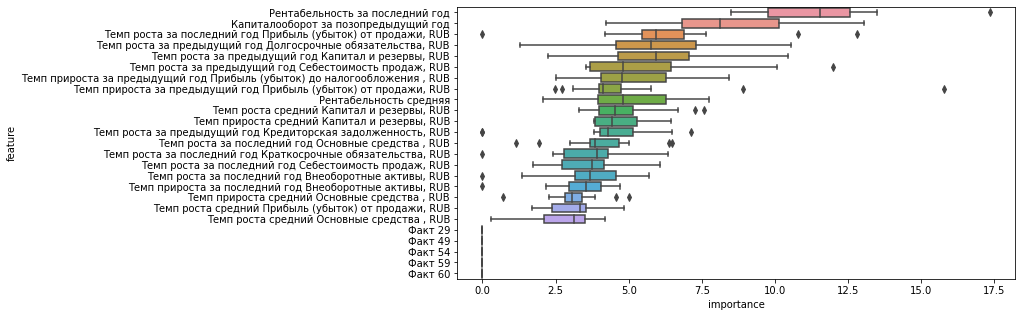

In [26]:
df_feats_imp = plot_importance(X, best, 0.20, top_n=30)

# Из графика видно, что 
вошли такие факты как: 60, 59, 54, 29, 49

Пробуем использовать эти оцененные факты

In [20]:
data_pack = pd.read_csv('data/agents2021.csv')
fact_cols = [
    'Факт 60',
    'Факт 59',
    'Факт 54',
    'Факт 29',
    'Факт 49'
]

y = get_answers(data_pack, 2021)
features = ['Рентабельность за последний год', 'Капиталооборот за позопредыдущий год', 'Темп роста за последний год Себестоимость продаж, RUB', 'Темп роста за последний год Прибыль (убыток) от продажи, RUB', 'Темп прироста за последний год Внеоборотные активы, RUB', 'Темп роста за последний год Внеоборотные активы, RUB', 'Темп прироста за предыдущий год Прибыль (убыток) до налогообложения , RUB', 'Темп роста средний Капитал и резервы, RUB', 'Темп роста за последний год Краткосрочные обязательства, RUB', 'Темп роста средний Прибыль (убыток) от продажи, RUB', 'Темп роста за предыдущий год Себестоимость продаж, RUB', 'Рентабельность средняя', 'Темп роста средний Основные средства , RUB', 'Темп роста за предыдущий год Капитал и резервы, RUB', 'Темп роста за предыдущий год Долгосрочные обязательства, RUB', 'Темп прироста средний Основные средства , RUB', 'Темп роста за предыдущий год Кредиторская задолженность, RUB', 'Темп роста за последний год Основные средства , RUB', 'Темп прироста средний Капитал и резервы, RUB', 'Темп прироста за предыдущий год Прибыль (убыток) от продажи, RUB']
X = get_predict_data(data_pack, 2021, features, fact_cols)

X['Факт наличия ПДЗ'] = y['Факт наличия ПДЗ']
X = X[~X.isin([np.nan, np.inf, -np.inf]).any(1)]
y = X['Факт наличия ПДЗ']
X = X.drop(['Факт наличия ПДЗ'], axis = 1)
X



,Рентабельность за последний год,Капиталооборот за позопредыдущий год,"Темп роста за последний год Себестоимость продаж, RUB","Темп роста за последний год Прибыль (убыток) от продажи, RUB","Темп прироста за последний год Внеоборотные активы, RUB","Темп роста за последний год Внеоборотные активы, RUB","Темп прироста за предыдущий год Прибыль (убыток) до налогообложения , RUB","Темп роста средний Капитал и резервы, RUB","Темп роста за последний год Краткосрочные обязательства, RUB","Темп роста средний Прибыль (убыток) от продажи, RUB",...,"Темп прироста средний Основные средства , RUB","Темп роста за предыдущий год Кредиторская задолженность, RUB","Темп роста за последний год Основные средства , RUB","Темп прироста средний Капитал и резервы, RUB","Темп прироста за предыдущий год Прибыль (убыток) от продажи, RUB",Факт 60,Факт 59,Факт 54,Факт 29,Факт 49
0,5.002895,6.094585,0.769902,1.632288,0.171838,1.171838,3.829626,1.769794,0.964588,2.914901,...,0.435599,0.635209,1.190219,0.769794,3.197514,yes,yes,yes,yes,yes
1,-22.691665,1.630231,1.024001,2.944574,0.055135,1.055135,-8.548748,0.865704,1.314372,2.121396,...,0.070788,0.931418,1.035230,-0.134296,0.298218,yes,yes,yes,yes,yes
2,0.678921,4.145944,1.067579,1.020412,0.038433,1.038433,0.079850,3.231432,0.672628,1.039843,...,0.045111,1.245402,1.084408,2.231432,0.059274,yes,yes,yes,yes,yes
3,1.468165,1.051329,1.074808,1.230115,0.073809,1.073809,-0.055642,0.968141,0.426093,1.187037,...,0.082381,2.315107,1.065881,-0.031859,0.143959,yes,yes,yes,yes,yes
4,-117.206969,2.848197,0.952352,1.512350,-0.400379,0.599621,-0.596656,5.806887,1.082186,0.885810,...,0.052151,1.087307,0.983819,4.806887,-0.740730,yes,yes,yes,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,-21.380912,4.867504,0.454696,0.474715,-0.073918,0.926082,-2.807390,0.549894,1.273711,0.003593,...,0.003252,0.465710,0.940105,-0.450106,-1.467528,yes,yes,yes,yes,yes
313,26.244441,1.927273,1.995224,2.145292,1.164961,2.164961,1.168380,1.153133,2.410501,1.450128,...,0.069678,1.613576,1.187845,0.153133,-0.245036,yes,yes,yes,yes,yes
314,44.244729,4.366372,1.529021,-1.117944,0.365009,1.365009,-0.325930,1.112493,1.270419,-0.324840,...,0.778202,1.760491,1.396364,0.112493,-0.531736,yes,yes,yes,yes,yes
318,33.977632,2.088020,1.072516,0.716711,-0.376869,0.623131,2.262061,2.938227,1.343751,2.538941,...,-0.541243,1.278513,0.623131,1.938227,3.361171,yes,yes,yes,yes,yes


In [14]:
clfs = train_with_categories(X, y, fact_cols)

Learning rate set to 0.007599
0:	learn: 0.7474033	test: 0.5171663	best: 0.5171663 (0)	total: 180ms	remaining: 29m 56s
500:	learn: 1.0000000	test: 0.5548187	best: 0.7080649 (6)	total: 1.35s	remaining: 25.6s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7080649054
bestIteration = 6

Shrink model to first 7 iterations.
	2, random state = 73
		model F1 = 0.7080649053972291
Learning rate set to 0.007599
0:	learn: 0.7100197	test: 0.4706461	best: 0.4706461 (0)	total: 2.8ms	remaining: 28s
500:	learn: 1.0000000	test: 0.6261029	best: 0.6722854 (350)	total: 1.31s	remaining: 24.8s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6722854345
bestIteration = 350

Shrink model to first 351 iterations.
	3, random state = 73
		model F1 = 0.672285434494533
Learning rate set to 0.007599
0:	learn: 0.7851072	test: 0.2880397	best: 0.2880397 (0)	total: 11ms	remaining: 1m 50s
500:	learn: 1.0000000	test: 0.5035572	best: 0.5035572 (57)	total: 1.2s	remaining: 22.8s
Stopp

500:	learn: 1.0000000	test: 0.5699914	best: 0.6359761 (3)	total: 1.35s	remaining: 25.7s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.635976143
bestIteration = 3

Shrink model to first 4 iterations.
	22, random state = 777
		model F1 = 0.6359761430004578
Learning rate set to 0.007599
0:	learn: 0.6602957	test: 0.6361640	best: 0.6361640 (0)	total: 14.2ms	remaining: 2m 21s
500:	learn: 1.0000000	test: 0.5526878	best: 0.6778681 (3)	total: 1.41s	remaining: 26.7s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6778680966
bestIteration = 3

Shrink model to first 4 iterations.
	23, random state = 777
		model F1 = 0.6778680965746204
Learning rate set to 0.007599
0:	learn: 0.6890032	test: 0.5047197	best: 0.5047197 (0)	total: 23.8ms	remaining: 3m 57s
500:	learn: 1.0000000	test: 0.6207236	best: 0.6207236 (437)	total: 1.35s	remaining: 25.7s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.620723635
bestIteration = 437

Shrink model to f

500:	learn: 1.0000000	test: 0.5171663	best: 0.6191823 (4)	total: 1.44s	remaining: 27.4s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6191823102
bestIteration = 4

Shrink model to first 5 iterations.
	43, random state = 1515
		model F1 = 0.6191823102262791
Learning rate set to 0.007599
0:	learn: 0.7266725	test: 0.4286187	best: 0.4286187 (0)	total: 3.34ms	remaining: 33.4s
500:	learn: 1.0000000	test: 0.6778681	best: 0.7258517 (78)	total: 1.41s	remaining: 26.8s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7258516797
bestIteration = 78

Shrink model to first 79 iterations.
	44, random state = 1515
		model F1 = 0.7258516797202743
Learning rate set to 0.00761
0:	learn: 0.7900406	test: 0.3376072	best: 0.3376072 (0)	total: 12.4ms	remaining: 2m 3s
500:	learn: 1.0000000	test: 0.6272613	best: 0.6272613 (155)	total: 1.39s	remaining: 26.3s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6272613125
bestIteration = 155

Shrink model 

In [16]:
i = 1
scores = []
best = []
for clf in clfs:
    score = clf.best_score_['validation']['F1']
    scores.append(score)
    best.append(clf)
    print(f'{i} model acuracy = {score}')
    dump(clf, f'models/top_facts/model_{i}.joblib')
    i += 1
print('mean AUC', np.mean(scores))
print('best AUC', np.max(scores))

1 model acuracy = 0.7080649053972291
2 model acuracy = 0.672285434494533
3 model acuracy = 0.5035572345115948
4 model acuracy = 0.7586206896551725
5 model acuracy = 0.8101260133752057
6 model acuracy = 0.6909928079700952
7 model acuracy = 0.5137264223316665
8 model acuracy = 0.6747245765970348
9 model acuracy = 0.7310482583253267
10 model acuracy = 0.6870620292062976
11 model acuracy = 0.6312053884376705
12 model acuracy = 0.5091179886282007
13 model acuracy = 0.6537063576272244
14 model acuracy = 0.7531251003253858
15 model acuracy = 0.41228347298219614
16 model acuracy = 0.5979423292075539
17 model acuracy = 0.687103952693307
18 model acuracy = 0.5699914204525232
19 model acuracy = 0.70837535743613
20 model acuracy = 0.8401775286721864
21 model acuracy = 0.6359761430004578
22 model acuracy = 0.6778680965746204
23 model acuracy = 0.6207236349748501
24 model acuracy = 0.7220648561147713
25 model acuracy = 0.5342893380915875
26 model acuracy = 0.6299332894426987
27 model acuracy = 0.586

In [17]:
i = 1
scores = []
best = []
for clf in clfs:
    score = clf.best_score_['validation']['F1']
    if score > 0.7:
        scores.append(score)
        best.append(clf)
        print(f'{i} model acuracy = {score}')
        dump(clf, f'models/top_facts/best/model_{i}.joblib')
        i += 1
print('mean AUC', np.mean(scores))
print('best AUC', np.max(scores))

1 model acuracy = 0.7080649053972291
2 model acuracy = 0.7586206896551725
3 model acuracy = 0.8101260133752057
4 model acuracy = 0.7310482583253267
5 model acuracy = 0.7531251003253858
6 model acuracy = 0.70837535743613
7 model acuracy = 0.8401775286721864
8 model acuracy = 0.7220648561147713
9 model acuracy = 0.8931964439854325
10 model acuracy = 0.7859756021578835
11 model acuracy = 0.7260348703249857
12 model acuracy = 0.7761532919408984
13 model acuracy = 0.71530687666645
14 model acuracy = 0.7258516797202743
15 model acuracy = 0.8036231261499529
mean AUC 0.7638496400164858
best AUC 0.8931964439854325


In [18]:
df = pd.read_csv('data/agents2020.csv')
df

,Наименование ДП,Факт. 1,Факт. 2,Факт. 3,Факт. 4,Факт. 5,Факт. 6,Факт 7,Факт. 8,Факт. 9,...,"2018, Себестоимость продаж, RUB","2019, Себестоимость продаж, RUB","2016, Прибыль (убыток) до налогообложения , RUB","2017, Прибыль (убыток) до налогообложения , RUB","2018, Прибыль (убыток) до налогообложения , RUB","2019, Прибыль (убыток) до налогообложения , RUB","2016, Прибыль (убыток) от продажи, RUB","2017, Прибыль (убыток) от продажи, RUB","2018, Прибыль (убыток) от продажи, RUB","2019, Прибыль (убыток) от продажи, RUB"
0,0,Х,Х,Х,Х,Х,Х,Х,Х,Х,...,3.438313e+10,2.673481e+10,3.179697e+09,6.167667e+09,7.461828e+08,3.603784e+09,3.280355e+09,6.200120e+09,8.716191e+08,3.658634e+09
1,1,Х,Х,Х,Х,Х,Х,Х,Х,Х,...,4.169796e+08,5.349955e+08,1.212357e+07,6.944586e+06,4.480064e+07,8.747516e+07,1.630064e+07,1.109172e+07,5.135732e+07,9.411019e+07
2,2,Х,Х,Х,Х,Х,Х,Х,Х,Х,...,2.316724e+09,2.460679e+09,5.026662e+08,3.644229e+08,8.552994e+07,-6.456439e+08,4.148586e+08,1.611318e+08,-9.298981e+07,-1.207210e+08
3,3,Х,Х,Х,Х,Х,Х,Х,Х,Х,...,1.171315e+10,1.272604e+10,4.100857e+09,4.481281e+09,6.840634e+09,3.999298e+09,4.903117e+09,5.186553e+09,7.869977e+09,4.029232e+09
4,4,Х,Х,Х,Х,Х,Х,Х,Х,Х,...,2.652547e+10,3.055828e+10,7.163980e+10,3.799862e+10,4.593606e+10,4.960408e+10,2.338912e+10,3.727984e+10,5.307524e+10,5.622122e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,526,Х,Х,Х,Х,Х,Х,Х,Х,Х,...,1.047255e+08,2.884618e+08,7.961783e+05,7.751592e+05,6.176433e+06,1.580637e+07,1.174522e+06,8.923567e+05,6.782166e+06,2.074204e+07
527,527,Х,Х,Х,Х,Х,Х,Х,Х,Х,...,1.008364e+09,9.064178e+08,1.490363e+08,1.553159e+08,8.043376e+07,6.917389e+07,1.426694e+08,1.465019e+08,6.499554e+07,7.620446e+07
528,528,Х,Х,Х,Х,Х,Х,Х,Х,Х,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
529,529,Х,Х,Х,Х,Х,Х,Х,Х,Х,...,1.300605e+08,5.352535e+08,1.160510e+06,5.324204e+07,1.720955e+08,4.331529e+07,3.604459e+06,7.276369e+07,2.052898e+08,1.427178e+08


In [25]:
models = []
for i in range(1,16):
    models.append(load(f'models/top_facts/best/model_{i}.joblib'))

fact_cols = [
    'Факт 60',
    'Факт 59',
    'Факт 54',
    'Факт 29',
    'Факт 49'
]

test_accu_cat(models, 2020, features, fact_cols)
test_accu_cat(models, 2021, features, fact_cols)

2
              precision    recall  f1-score   support

          no       0.99      0.64      0.78       525
         yes       0.02      0.50      0.03         6

    accuracy                           0.64       531
   macro avg       0.50      0.57      0.41       531
weighted avg       0.98      0.64      0.77       531

3
              precision    recall  f1-score   support

          no       0.99      0.71      0.83       525
         yes       0.02      0.50      0.04         6

    accuracy                           0.71       531
   macro avg       0.51      0.61      0.43       531
weighted avg       0.98      0.71      0.82       531

4
              precision    recall  f1-score   support

          no       1.00      0.67      0.80       525
         yes       0.03      0.83      0.05         6

    accuracy                           0.67       531
   macro avg       0.51      0.75      0.43       531
weighted avg       0.99      0.67      0.79       531

5
           

16
              precision    recall  f1-score   support

          no       0.89      0.91      0.90       214
         yes       0.81      0.78      0.80       111

    accuracy                           0.86       325
   macro avg       0.85      0.85      0.85       325
weighted avg       0.86      0.86      0.86       325

16 mean acuracy = 0.8590769230769231


# Пробуем на самых оптимальных признаках обучить модели группирующие по срокам просрочки


In [28]:
data_pack = pd.read_csv('data/agents2021.csv')
fact_cols = [
    'Факт 60',
    'Факт 59',
    'Факт 54',
    'Факт 29',
    'Факт 49'
]

features = ['Рентабельность за последний год', 'Капиталооборот за позопредыдущий год', 'Темп роста за последний год Себестоимость продаж, RUB', 'Темп роста за последний год Прибыль (убыток) от продажи, RUB', 'Темп прироста за последний год Внеоборотные активы, RUB', 'Темп роста за последний год Внеоборотные активы, RUB', 'Темп прироста за предыдущий год Прибыль (убыток) до налогообложения , RUB', 'Темп роста средний Капитал и резервы, RUB', 'Темп роста за последний год Краткосрочные обязательства, RUB', 'Темп роста средний Прибыль (убыток) от продажи, RUB', 'Темп роста за предыдущий год Себестоимость продаж, RUB', 'Рентабельность средняя', 'Темп роста средний Основные средства , RUB', 'Темп роста за предыдущий год Капитал и резервы, RUB', 'Темп роста за предыдущий год Долгосрочные обязательства, RUB', 'Темп прироста средний Основные средства , RUB', 'Темп роста за предыдущий год Кредиторская задолженность, RUB', 'Темп роста за последний год Основные средства , RUB', 'Темп прироста средний Капитал и резервы, RUB', 'Темп прироста за предыдущий год Прибыль (убыток) от продажи, RUB']
X = get_predict_data(data_pack, 2021, features, fact_cols)

y1 = get_answers_group(data_pack, 2021, 1)
y2 = get_answers_group(data_pack, 2021, 2)
y3 = get_answers_group(data_pack, 2021, 3)
y4 = get_answers_group(data_pack, 2021, 4)

X['Группа ПДЗ 1-30'] = y1['Группа ПДЗ 1-30']
X['Группа ПДЗ 31-90'] = y2['Группа ПДЗ 31-90']
X['Группа ПДЗ 91-365'] = y3['Группа ПДЗ 91-365']
X['Группа ПДЗ 365+'] = y4['Группа ПДЗ 365+']

X = X[~X.isin([np.nan, np.inf, -np.inf]).any(1)]

y1 = X['Группа ПДЗ 1-30']
y2 = X['Группа ПДЗ 31-90']
y3 = X['Группа ПДЗ 91-365']
y4 = X['Группа ПДЗ 365+']
X = X.drop(['Группа ПДЗ 1-30', 'Группа ПДЗ 31-90', 'Группа ПДЗ 91-365', 'Группа ПДЗ 365+'], axis = 1)
X


,Рентабельность за последний год,Капиталооборот за позопредыдущий год,"Темп роста за последний год Себестоимость продаж, RUB","Темп роста за последний год Прибыль (убыток) от продажи, RUB","Темп прироста за последний год Внеоборотные активы, RUB","Темп роста за последний год Внеоборотные активы, RUB","Темп прироста за предыдущий год Прибыль (убыток) до налогообложения , RUB","Темп роста средний Капитал и резервы, RUB","Темп роста за последний год Краткосрочные обязательства, RUB","Темп роста средний Прибыль (убыток) от продажи, RUB",...,"Темп прироста средний Основные средства , RUB","Темп роста за предыдущий год Кредиторская задолженность, RUB","Темп роста за последний год Основные средства , RUB","Темп прироста средний Капитал и резервы, RUB","Темп прироста за предыдущий год Прибыль (убыток) от продажи, RUB",Факт 60,Факт 59,Факт 54,Факт 29,Факт 49
0,5.002895,6.094585,0.769902,1.632288,0.171838,1.171838,3.829626,1.769794,0.964588,2.914901,...,0.435599,0.635209,1.190219,0.769794,3.197514,yes,yes,yes,yes,yes
1,-22.691665,1.630231,1.024001,2.944574,0.055135,1.055135,-8.548748,0.865704,1.314372,2.121396,...,0.070788,0.931418,1.035230,-0.134296,0.298218,yes,yes,yes,yes,yes
2,0.678921,4.145944,1.067579,1.020412,0.038433,1.038433,0.079850,3.231432,0.672628,1.039843,...,0.045111,1.245402,1.084408,2.231432,0.059274,yes,yes,yes,yes,yes
3,1.468165,1.051329,1.074808,1.230115,0.073809,1.073809,-0.055642,0.968141,0.426093,1.187037,...,0.082381,2.315107,1.065881,-0.031859,0.143959,yes,yes,yes,yes,yes
4,-117.206969,2.848197,0.952352,1.512350,-0.400379,0.599621,-0.596656,5.806887,1.082186,0.885810,...,0.052151,1.087307,0.983819,4.806887,-0.740730,yes,yes,yes,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,-21.380912,4.867504,0.454696,0.474715,-0.073918,0.926082,-2.807390,0.549894,1.273711,0.003593,...,0.003252,0.465710,0.940105,-0.450106,-1.467528,yes,yes,yes,yes,yes
313,26.244441,1.927273,1.995224,2.145292,1.164961,2.164961,1.168380,1.153133,2.410501,1.450128,...,0.069678,1.613576,1.187845,0.153133,-0.245036,yes,yes,yes,yes,yes
314,44.244729,4.366372,1.529021,-1.117944,0.365009,1.365009,-0.325930,1.112493,1.270419,-0.324840,...,0.778202,1.760491,1.396364,0.112493,-0.531736,yes,yes,yes,yes,yes
318,33.977632,2.088020,1.072516,0.716711,-0.376869,0.623131,2.262061,2.938227,1.343751,2.538941,...,-0.541243,1.278513,0.623131,1.938227,3.361171,yes,yes,yes,yes,yes


In [30]:
clfs1 = train_with_categories(X, y1, fact_cols)
clfs2 = train_with_categories(X, y2, fact_cols)
clfs3 = train_with_categories(X, y3, fact_cols)
clfs4 = train_with_categories(X, y4, fact_cols)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.007599
0:	learn: 0.7800498	test: 0.2779949	best: 0.2779949 (0)	total: 3.32ms	remaining: 33.2s
500:	learn: 1.0000000	test: 0.0000000	best: 0.3280201 (1)	total: 1.31s	remaining: 24.9s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.3280200585
bestIteration = 1

Shrink model to first 2 iterations.
	2, random state = 73
		model F1 = 0.328020058535381
Learning rate set to 0.007599
0:	learn: 0.6682701	test: 0.2979930	best: 0.2979930 (0)	total: 11.9ms	remaining: 1m 58s
500:	learn: 1.0000000	test: 0.0000000	best: 0.3333333 (2)	total: 1.32s	remaining: 25.1s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.3333333333
bestIteration = 2

Shrink model to first 3 iterations.
	3, random state = 73
		model F1 = 0.33333333333333337
Learning rate set to 0.007599
0:	learn: 0.5985217	test: 0.2722688	best: 0.2722688 (0)	total: 17.4ms	remaining: 2m 53s
500:	learn: 1.0000000	test: 0.0000000	best: 0.2722688 (0)	total: 1.26s	remaining: 23.9s
Stopp

500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.32s	remaining: 25s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	23, random state = 777
		model F1 = 0.0
Learning rate set to 0.007599
0:	learn: 0.5536456	test: 0.3755906	best: 0.3755906 (0)	total: 2.7ms	remaining: 27s
500:	learn: 1.0000000	test: 0.0000000	best: 0.3755906 (0)	total: 1.35s	remaining: 25.5s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.3755906465
bestIteration = 0

Shrink model to first 1 iterations.
	24, random state = 777
		model F1 = 0.3755906465178586
Learning rate set to 0.00761
0:	learn: 0.6667991	test: 0.0000000	best: 0.0000000 (0)	total: 28.4ms	remaining: 4m 43s
500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.38s	remaining: 26.1s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	25, random state = 777
		m

500:	learn: 1.0000000	test: 0.0000000	best: 0.4000000 (7)	total: 1.43s	remaining: 27s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.4
bestIteration = 7

Shrink model to first 8 iterations.
	45, random state = 1515
		model F1 = 0.4
Learning rate set to 0.00761
0:	learn: 0.6575353	test: 0.3096799	best: 0.3096799 (0)	total: 11ms	remaining: 1m 50s
500:	learn: 1.0000000	test: 0.0000000	best: 0.3282073 (3)	total: 1.41s	remaining: 26.7s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.3282072599
bestIteration = 3

Shrink model to first 4 iterations.
	46, random state = 1515
		model F1 = 0.3282072598954878
models mean F1 = 0.30086789570642936
Learning rate set to 0.007599
0:	learn: 0.8077498	test: 0.0000000	best: 0.0000000 (0)	total: 16.7ms	remaining: 2m 46s
500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.35s	remaining: 25.7s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to firs

500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.36s	remaining: 25.9s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	22, random state = 777
		model F1 = 0.0
Learning rate set to 0.007599
0:	learn: 0.9363278	test: 0.0000000	best: 0.0000000 (0)	total: 15.8ms	remaining: 2m 37s
500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.43s	remaining: 27.2s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	23, random state = 777
		model F1 = 0.0
Learning rate set to 0.007599
0:	learn: 0.6651862	test: 0.0000000	best: 0.0000000 (0)	total: 2.84ms	remaining: 28.4s
500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.35s	remaining: 25.6s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	24, random state = 777
		model F1 = 0.0
Learni

500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.38s	remaining: 26.1s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	45, random state = 1515
		model F1 = 0.0
Learning rate set to 0.00761
0:	learn: 0.8805819	test: 0.0000000	best: 0.0000000 (0)	total: 18.9ms	remaining: 3m 8s
500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.5s	remaining: 28.4s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	46, random state = 1515
		model F1 = 0.0
models mean F1 = 0.3076338104355442
Learning rate set to 0.007599
0:	learn: 0.7210990	test: 0.5478264	best: 0.5478264 (0)	total: 17.7ms	remaining: 2m 57s
500:	learn: 1.0000000	test: 0.0000000	best: 0.5478264 (0)	total: 1.47s	remaining: 27.9s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5478264282
bestIteration = 0

Shrink model to first 1 iterations.


500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.57s	remaining: 29.7s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	22, random state = 777
		model F1 = 0.0
Learning rate set to 0.007599
0:	learn: 0.6500000	test: 0.0000000	best: 0.0000000 (0)	total: 4.89ms	remaining: 48.9s
500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.53s	remaining: 28.9s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	23, random state = 777
		model F1 = 0.0
Learning rate set to 0.007599
0:	learn: 0.6933333	test: 0.0000000	best: 0.0000000 (0)	total: 8.13ms	remaining: 1m 21s
500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.46s	remaining: 27.6s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	24, random state = 777
		model F1 = 0.0
Learni

500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.38s	remaining: 26.1s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	44, random state = 1515
		model F1 = 0.0
Learning rate set to 0.00761
0:	learn: 0.7566417	test: 0.0000000	best: 0.0000000 (0)	total: 2.77ms	remaining: 27.7s
500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.4s	remaining: 26.5s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	45, random state = 1515
		model F1 = 0.0
Learning rate set to 0.00761
0:	learn: 0.6501724	test: 0.0000000	best: 0.0000000 (0)	total: 11.5ms	remaining: 1m 55s
500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.44s	remaining: 27.2s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	46, random state = 1515
		model F1 = 0.0
models

500:	learn: 1.0000000	test: 0.6276227	best: 0.8015312 (84)	total: 1.42s	remaining: 27s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8015311787
bestIteration = 84

Shrink model to first 85 iterations.
	20, random state = 322
		model F1 = 0.8015311786893993
Learning rate set to 0.00761
0:	learn: 0.8068081	test: 0.7593402	best: 0.7593402 (0)	total: 16.6ms	remaining: 2m 46s
500:	learn: 1.0000000	test: 0.8014947	best: 0.8765325 (4)	total: 1.44s	remaining: 27.4s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8765324839
bestIteration = 4

Shrink model to first 5 iterations.
	21, random state = 322
		model F1 = 0.876532483924261
Learning rate set to 0.007599
0:	learn: 0.8306570	test: 0.6909113	best: 0.6909113 (0)	total: 11.2ms	remaining: 1m 52s
500:	learn: 1.0000000	test: 0.6163846	best: 0.7698552 (2)	total: 1.43s	remaining: 27.2s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7698552499
bestIteration = 2

Shrink model to firs

500:	learn: 1.0000000	test: 0.7523112	best: 0.7754230 (103)	total: 1.43s	remaining: 27.2s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7754230497
bestIteration = 103

Shrink model to first 104 iterations.
	41, random state = 2402
		model F1 = 0.775423049683254
Learning rate set to 0.007599
0:	learn: 0.8148977	test: 0.6745256	best: 0.6745256 (0)	total: 12.9ms	remaining: 2m 8s
500:	learn: 1.0000000	test: 0.2782093	best: 0.6897874 (1)	total: 1.43s	remaining: 27s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6897874413
bestIteration = 1

Shrink model to first 2 iterations.
	42, random state = 1515
		model F1 = 0.6897874413282934
Learning rate set to 0.007599
0:	learn: 0.8445105	test: 0.3346127	best: 0.3346127 (0)	total: 9.82ms	remaining: 1m 38s
500:	learn: 1.0000000	test: 0.3485213	best: 0.5733074 (20)	total: 1.42s	remaining: 27s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.573307385
bestIteration = 20

Shrink model to 

In [35]:

best1 = dump_best(clfs1, 'group1', 0.6)
best2 = dump_best(clfs2, 'group2', 0.6)
best3 = dump_best(clfs3, 'group3', 0.6)
best4 = dump_best(clfs4, 'group4', 0.6)

1 model acuracy = 0.628364758848476
2 model acuracy = 0.628364758848476
mean AUC 0.628364758848476
best AUC 0.628364758848476
1 model acuracy = 0.9218646504711814
2 model acuracy = 1.0
3 model acuracy = 1.0
4 model acuracy = 1.0
5 model acuracy = 1.0
6 model acuracy = 1.0
7 model acuracy = 1.0
8 model acuracy = 1.0
9 model acuracy = 1.0
10 model acuracy = 1.0
11 model acuracy = 1.0
12 model acuracy = 1.0
13 model acuracy = 1.0
14 model acuracy = 0.9216568191283073
mean AUC 0.9888229621142492
best AUC 1.0
1 model acuracy = 0.7434202316203753
2 model acuracy = 1.0
3 model acuracy = 0.6217106728115792
4 model acuracy = 1.0
5 model acuracy = 0.6217106728115792
mean AUC 0.7973683154487067
best AUC 1.0
1 model acuracy = 0.7418138819923689
2 model acuracy = 0.7058823529411764
3 model acuracy = 0.6896667320983553
4 model acuracy = 0.6913223062862958
5 model acuracy = 0.801505481077079
6 model acuracy = 0.8913228549372368
7 model acuracy = 0.7515852434708075
8 model acuracy = 0.6163845963431779

In [40]:
fact_cols = [
    'Факт 60',
    'Факт 59',
    'Факт 54',
    'Факт 29',
    'Факт 49'
]

features = ['Рентабельность за последний год', 'Капиталооборот за позопредыдущий год', 'Темп роста за последний год Себестоимость продаж, RUB', 'Темп роста за последний год Прибыль (убыток) от продажи, RUB', 'Темп прироста за последний год Внеоборотные активы, RUB', 'Темп роста за последний год Внеоборотные активы, RUB', 'Темп прироста за предыдущий год Прибыль (убыток) до налогообложения , RUB', 'Темп роста средний Капитал и резервы, RUB', 'Темп роста за последний год Краткосрочные обязательства, RUB', 'Темп роста средний Прибыль (убыток) от продажи, RUB', 'Темп роста за предыдущий год Себестоимость продаж, RUB', 'Рентабельность средняя', 'Темп роста средний Основные средства , RUB', 'Темп роста за предыдущий год Капитал и резервы, RUB', 'Темп роста за предыдущий год Долгосрочные обязательства, RUB', 'Темп прироста средний Основные средства , RUB', 'Темп роста за предыдущий год Кредиторская задолженность, RUB', 'Темп роста за последний год Основные средства , RUB', 'Темп прироста средний Капитал и резервы, RUB', 'Темп прироста за предыдущий год Прибыль (убыток) от продажи, RUB']

year = 2020
test_accu_cat_group(best1, year, features, fact_cols, 1)



2
              precision    recall  f1-score   support

          no       0.47      0.87      0.61       251
         yes       0.52      0.13      0.21       280

    accuracy                           0.48       531
   macro avg       0.50      0.50      0.41       531
weighted avg       0.50      0.48      0.40       531

3
              precision    recall  f1-score   support

          no       0.49      0.88      0.63       251
         yes       0.62      0.17      0.26       280

    accuracy                           0.51       531
   macro avg       0.55      0.53      0.45       531
weighted avg       0.56      0.51      0.44       531

3 mean acuracy = 0.4924670433145009


In [41]:

test_accu_cat_group(best2, year, features, fact_cols, 2)

2
              precision    recall  f1-score   support

          no       0.91      0.98      0.94       481
         yes       0.08      0.02      0.03        50

    accuracy                           0.89       531
   macro avg       0.49      0.50      0.49       531
weighted avg       0.83      0.89      0.85       531

3
              precision    recall  f1-score   support

          no       0.91      0.96      0.93       481
         yes       0.16      0.08      0.11        50

    accuracy                           0.87       531
   macro avg       0.53      0.52      0.52       531
weighted avg       0.84      0.87      0.85       531

4
              precision    recall  f1-score   support

          no       0.91      0.98      0.94       481
         yes       0.09      0.02      0.03        50

    accuracy                           0.89       531
   macro avg       0.50      0.50      0.49       531
weighted avg       0.83      0.89      0.86       531

5
           

In [42]:

test_accu_cat_group(best3, year, features, fact_cols, 3)

2
              precision    recall  f1-score   support

          no       0.95      0.92      0.94       504
         yes       0.05      0.07      0.06        27

    accuracy                           0.88       531
   macro avg       0.50      0.50      0.50       531
weighted avg       0.90      0.88      0.89       531

3
              precision    recall  f1-score   support

          no       0.95      1.00      0.97       504
         yes       0.00      0.00      0.00        27

    accuracy                           0.95       531
   macro avg       0.47      0.50      0.49       531
weighted avg       0.90      0.95      0.92       531

4
              precision    recall  f1-score   support

          no       0.95      0.97      0.96       504
         yes       0.11      0.07      0.09        27

    accuracy                           0.92       531
   macro avg       0.53      0.52      0.52       531
weighted avg       0.91      0.92      0.92       531

5
           

In [43]:

test_accu_cat_group(best4, year, features, fact_cols, 4)

2
              precision    recall  f1-score   support

          no       0.99      0.79      0.88       525
         yes       0.03      0.50      0.05         6

    accuracy                           0.79       531
   macro avg       0.51      0.65      0.47       531
weighted avg       0.98      0.79      0.87       531

3
              precision    recall  f1-score   support

          no       0.99      0.83      0.90       525
         yes       0.03      0.50      0.06         6

    accuracy                           0.83       531
   macro avg       0.51      0.67      0.48       531
weighted avg       0.98      0.83      0.90       531

4
              precision    recall  f1-score   support

          no       1.00      0.85      0.92       525
         yes       0.05      0.67      0.09         6

    accuracy                           0.85       531
   macro avg       0.52      0.76      0.50       531
weighted avg       0.98      0.85      0.91       531

5
           

35
              precision    recall  f1-score   support

          no       0.99      0.79      0.88       525
         yes       0.03      0.50      0.05         6

    accuracy                           0.78       531
   macro avg       0.51      0.64      0.46       531
weighted avg       0.98      0.78      0.87       531

36
              precision    recall  f1-score   support

          no       1.00      0.85      0.92       525
         yes       0.05      0.67      0.09         6

    accuracy                           0.85       531
   macro avg       0.52      0.76      0.50       531
weighted avg       0.98      0.85      0.91       531

36 mean acuracy = 0.8086629001883239
